In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from us_states_abbrev import *

In [3]:
covid_path = "data/covid/us_states_covid19_daily.csv"
covid_all_path = "data/covid/us_covid19_daily.csv"
traffic_path = "data/traffic/US_Accidents_June20.csv"

covid_data = pd.read_csv(covid_path, usecols=['date', 'state', 'positive', 'negative', 'totalTestResults', 'hospitalizedCurrently', 'hospitalizedCumulative', 'death'])
covid_all_data = pd.read_csv(covid_all_path, usecols=['date', 'positive'])
traffic_data = pd.read_csv(traffic_path, usecols=['Start_Time', 'State'])
traffic_data = traffic_data.rename(columns={'State': 'state'})

In [4]:
#Convert state 2-letter code to full name
covid_data['state'] = covid_data['state'].map(abbrev_us_state)
traffic_data['state'] = traffic_data['state'].map(abbrev_us_state)

In [5]:
covid_unique = covid_data['state'].unique()
traffic_unique = traffic_data['state'].unique()


In [6]:
#Discovers the states that are included in the Covid dataset but not the traffic dataset
contains = False
difference = []
for covid_state in covid_unique:
    for traffic_state in traffic_unique:
        if covid_state == traffic_state:
            contains = True
    if(contains == False):
        difference.append(covid_state)
    contains = False



In [7]:
# Convert date column to datetime object
covid_data['date'] = pd.to_datetime(covid_data['date'], format='%Y%m%d')
traffic_data['date'] = pd.to_datetime(traffic_data['Start_Time'], format='%Y-%m-%d %H:%M:%S').dt.date
covid_all_data['date'] = pd.to_datetime(covid_all_data['date'], format='%Y%m%d')

# Remove Start_Time column from traffic_data
traffic_data = traffic_data[['date', 'state']]

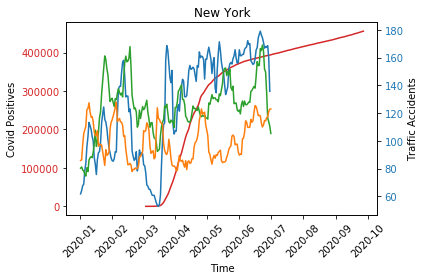

In [15]:
import datetime
def plot_covid_state(state, moving_avg_window):

    # Extract the covid data for the given state
    state_covid_data = covid_data.loc[covid_data['state'] == state]

    # Extract the traffic data for the given state
    state_traffic_data = traffic_data.loc[traffic_data['state'] == state]
    
    # Merge rows with same date and add a counter column
    # TODO: Make sure this is done correctly
    state_traffic_data['count'] = state_traffic_data.groupby(['date'])['date'].transform('size')
    state_traffic_data.drop_duplicates(keep='first', inplace=True)
    state_traffic_data = state_traffic_data.sort_values(by='date')

    # Apply moving average to data
    state_traffic_data['count'] = state_traffic_data['count'].rolling(window = moving_avg_window).mean()

    # Traffic data 2020 to June
    start_date = pd.to_datetime('2020-01-01', format='%Y-%m-%d', errors='ignore')
    end_date = pd.to_datetime('2021-01-01', format='%Y-%m-%d', errors='ignore')
    mask = (state_traffic_data['date'] > start_date) & (state_traffic_data['date'] <= end_date)
    state_traffic_data_2020 = state_traffic_data.loc[mask]

    # Traffic data 2019 to June
    start_date = pd.to_datetime('2019-01-01', format='%Y-%m-%d', errors='ignore')
    end_date = pd.to_datetime('2019-07-01', format='%Y-%m-%d', errors='ignore')
    mask = (state_traffic_data['date'] > start_date) & (state_traffic_data['date'] <= end_date)
    state_traffic_data_2019 = state_traffic_data.loc[mask]
    state_traffic_data_2019['date'] = state_traffic_data_2019['date'] + pd.DateOffset(years=1)
    
    # Traffic data 2018 to June
    start_date = pd.to_datetime('2018-01-01', format='%Y-%m-%d', errors='ignore')
    end_date = pd.to_datetime('2018-07-01', format='%Y-%m-%d', errors='ignore')
    mask = (state_traffic_data['date'] > start_date) & (state_traffic_data['date'] <= end_date)
    state_traffic_data_2018 = state_traffic_data.loc[mask]
    state_traffic_data_2018['date'] = state_traffic_data_2018['date'] + pd.DateOffset(years=2)


    fig, ax1 = plt.subplots()
    plt.xticks(rotation = 45)

    # Plot covid cases
    dates_covid = state_covid_data['date']
    positives = state_covid_data['positive']

    color = 'tab:red'
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Covid Positives')
    ax1.plot(dates_covid, positives, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx() # Instantiate a second axes that shares the same x-axis

    # Plot traffic accidents 2020
    dates_traffic = state_traffic_data_2020['date']
    accidents = state_traffic_data_2020['count']

    color = 'tab:blue'
    ax2.set_ylabel('Traffic Accidents')
    ax2.plot(dates_traffic, accidents, color=color)

    # Plot traffic accidents 2019
    dates_traffic = state_traffic_data_2019['date']
    accidents = state_traffic_data_2019['count']

    color = 'tab:green'
    ax2.plot(dates_traffic, accidents, color=color)

    # Plot taffic accidents 2018
    dates_traffic = state_traffic_data_2018['date']
    accidents = state_traffic_data_2018['count']

    color = 'tab:orange'
    ax2.plot(dates_traffic, accidents, color=color)
    
    ax2.set_xticklabels(['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November'])

    
    ax2.tick_params(axis='y', labelcolor='tab:blue')


    # Show figure
    plt.title(state)
    fig.tight_layout()
    plt.show()

plot_covid_state('New York', 7)

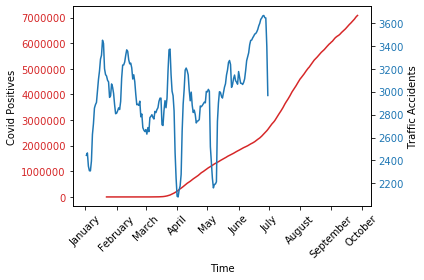

In [19]:
def plot_covid_country(moving_avg_window):

    covid_all = covid_all_data

    all_traffic_data = traffic_data.copy()
    all_traffic_data = all_traffic_data[['date']]

    # Merge rows with the same date and add a counter column
    all_traffic_data['count'] = all_traffic_data.groupby(['date'])['date'].transform('size')
    all_traffic_data.drop_duplicates(keep='first', inplace=True)
    all_traffic_data = all_traffic_data.sort_values(by='date')
    
    # Apply moving average to data
    all_traffic_data['count'] = all_traffic_data['count'].rolling(window = moving_avg_window).mean()

    # Remove rows before and after the start and end date
    start_date = pd.to_datetime('2020-01-01', format='%Y-%m-%d', errors='ignore')
    end_date = pd.to_datetime('2021-01-01', format='%Y-%m-%d', errors='ignore')
    mask = (all_traffic_data['date'] > start_date) & (all_traffic_data['date'] <= end_date)
    all_traffic_data = all_traffic_data.loc[mask]

    fig, ax1 = plt.subplots()
    plt.xticks(rotation = 45)

    # Plot covid cases
    dates_covid = covid_all['date']
    positives = covid_all['positive']

    color = 'tab:red'
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Covid Positives')
    ax1.plot(dates_covid, positives, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx() # Instantiate a second axes that shares the same x-axis

    # Plot traffic accidents
    dates_traffic = all_traffic_data['date']
    accidents = all_traffic_data['count']

    color = 'tab:blue'
    ax2.set_ylabel('Traffic Accidents')
    ax2.plot(dates_traffic, accidents, color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_xticklabels(['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November'])


    # Show figure
    fig.tight_layout()
    plt.show()

plot_covid_country(7)    

